In [1]:
import os
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook as tqdm

from utils import *

In [23]:
FEATURE_GENERATION = '7gen'
CITY = 'kazan'

In [26]:
dm_filename = './{}/dm_{}.pickle'.format(FEATURE_GENERATION, CITY)
if not os.path.exists(dm_filename):
    dm = DataManager(city_name=CITY, n_stations=2)
    with open(dm_filename, 'wb') as f:
        pickle.dump(dm, f)
else:
    with open(dm_filename, 'rb') as f:
        dm = pickle.load(f)
        
X, y, block_ids = dm.X_train, dm.y_train, dm.train_block_ids
X_test, test_block_ids = dm.X_test, dm.test_block_ids

in_train = block_ids['hours_since'] <= np.percentile(block_ids['hours_since'], 85)  #leave last 15% for validation
X_train, y_train = X[in_train], y[in_train]
X_val, y_val = X[~in_train], y[~in_train]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

Loading train df...
Loading train netatmo df...
Preprocessing train netatmo df...
Extracting features...


100%|██████████| 46281/46281 [22:12<00:00, 34.73it/s]  


Loading test df...
Loading test netatmo df
Extracting features...


100%|██████████| 14836/14836 [07:49<00:00, 31.61it/s]


Postprocessing nans...


((39414, 260), (6867, 260), (39414,), (6867,))

In [4]:
model = CatBoostClassifier(random_seed=1,
                           thread_count=4,
                           eval_metric='AUC',
                           verbose=True) \
            .fit(X_train, y_train, eval_set=(X_val, y_val))

Borders for float features generated
0:	learn 0.7986127802	test 0.517262002	bestTest 0.517262002		total: 183ms	remaining: 1m 31s
1:	learn 0.8162653757	test 0.5539284687	bestTest 0.5539284687		total: 328ms	remaining: 1m 21s
2:	learn 0.8199335954	test 0.5845476368	bestTest 0.5845476368		total: 464ms	remaining: 1m 16s
3:	learn 0.8224141742	test 0.570921564	bestTest 0.5845476368		total: 583ms	remaining: 1m 12s
4:	learn 0.82423863	test 0.5589850788	bestTest 0.5845476368		total: 729ms	remaining: 1m 12s
5:	learn 0.8234994742	test 0.5655589433	bestTest 0.5845476368		total: 873ms	remaining: 1m 11s
6:	learn 0.8253142687	test 0.5683869888	bestTest 0.5845476368		total: 977ms	remaining: 1m 8s
7:	learn 0.8272839124	test 0.5712980335	bestTest 0.5845476368		total: 1.09s	remaining: 1m 7s
8:	learn 0.8275877442	test 0.5845100157	bestTest 0.5845476368		total: 1.23s	remaining: 1m 7s
9:	learn 0.8276408913	test 0.5848030982	bestTest 0.5848030982		total: 1.39s	remaining: 1m 8s
10:	learn 0.8283701488	test 0.58

89:	learn 0.8788146676	test 0.6638354322	bestTest 0.6638354322		total: 12.4s	remaining: 56.5s
90:	learn 0.8789964141	test 0.6644627088	bestTest 0.6644627088		total: 12.6s	remaining: 56.5s
91:	learn 0.8794728859	test 0.6657993563	bestTest 0.6657993563		total: 12.7s	remaining: 56.4s
92:	learn 0.879715704	test 0.6666867485	bestTest 0.6666867485		total: 12.8s	remaining: 56.1s
93:	learn 0.8799227206	test 0.6675516456	bestTest 0.6675516456		total: 13s	remaining: 56.1s
94:	learn 0.8804632436	test 0.6668928241	bestTest 0.6675516456		total: 13.1s	remaining: 55.9s
95:	learn 0.880900371	test 0.6668330958	bestTest 0.6675516456		total: 13.2s	remaining: 55.7s
96:	learn 0.8811845247	test 0.6672010326	bestTest 0.6675516456		total: 13.4s	remaining: 55.5s
97:	learn 0.8816572019	test 0.6676105982	bestTest 0.6676105982		total: 13.5s	remaining: 55.3s
98:	learn 0.8817420755	test 0.6678236551	bestTest 0.6678236551		total: 13.6s	remaining: 55.1s
99:	learn 0.8821303243	test 0.6680860977	bestTest 0.6680860977		

177:	learn 0.9056146532	test 0.6910566793	bestTest 0.6910566793		total: 24.4s	remaining: 44.1s
178:	learn 0.9059272936	test 0.6911417469	bestTest 0.6911417469		total: 24.5s	remaining: 44s
179:	learn 0.9060384663	test 0.6910891291	bestTest 0.6911417469		total: 24.7s	remaining: 43.8s
180:	learn 0.9063309808	test 0.690520288	bestTest 0.6911417469		total: 24.8s	remaining: 43.7s
181:	learn 0.9066705445	test 0.690945626	bestTest 0.6911417469		total: 24.9s	remaining: 43.6s
182:	learn 0.9067514704	test 0.6910575843	bestTest 0.6911417469		total: 25.1s	remaining: 43.5s
183:	learn 0.906885474	test 0.690919511	bestTest 0.6911417469		total: 25.2s	remaining: 43.3s
184:	learn 0.9070970395	test 0.6907529957	bestTest 0.6911417469		total: 25.4s	remaining: 43.2s
185:	learn 0.9073689483	test 0.6909492459	bestTest 0.6911417469		total: 25.5s	remaining: 43.1s
186:	learn 0.9074842161	test 0.6912494389	bestTest 0.6912494389		total: 25.7s	remaining: 43s
187:	learn 0.9080399058	test 0.6913489861	bestTest 0.69134

264:	learn 0.9207230291	test 0.7052378894	bestTest 0.7058780942		total: 36.5s	remaining: 32.4s
265:	learn 0.9208560501	test 0.7054031119	bestTest 0.7058780942		total: 36.7s	remaining: 32.3s
266:	learn 0.920983742	test 0.7050343994	bestTest 0.7058780942		total: 36.8s	remaining: 32.1s
267:	learn 0.9211632661	test 0.7046522415	bestTest 0.7058780942		total: 36.9s	remaining: 32s
268:	learn 0.921359607	test 0.7049819109	bestTest 0.7058780942		total: 37.1s	remaining: 31.8s
269:	learn 0.9215154764	test 0.7051398936	bestTest 0.7058780942		total: 37.2s	remaining: 31.7s
270:	learn 0.9216918475	test 0.7052769326	bestTest 0.7058780942		total: 37.4s	remaining: 31.6s
271:	learn 0.9219130136	test 0.7050959376	bestTest 0.7058780942		total: 37.5s	remaining: 31.4s
272:	learn 0.9220859167	test 0.705454049	bestTest 0.7058780942		total: 37.7s	remaining: 31.3s
273:	learn 0.922359548	test 0.7057071833	bestTest 0.7058780942		total: 37.8s	remaining: 31.2s
274:	learn 0.9225154578	test 0.7060391797	bestTest 0.706

352:	learn 0.9330091325	test 0.7148507878	bestTest 0.7156595765		total: 48.8s	remaining: 20.3s
353:	learn 0.9331372694	test 0.7148368253	bestTest 0.7156595765		total: 49s	remaining: 20.2s
354:	learn 0.9332355006	test 0.715016786	bestTest 0.7156595765		total: 49.1s	remaining: 20.1s
355:	learn 0.9335973	test 0.7141172413	bestTest 0.7156595765		total: 49.2s	remaining: 19.9s
356:	learn 0.9337816706	test 0.7139879592	bestTest 0.7156595765		total: 49.4s	remaining: 19.8s
357:	learn 0.9338415399	test 0.7140378621	bestTest 0.7156595765		total: 49.5s	remaining: 19.6s
358:	learn 0.9340164082	test 0.714593775	bestTest 0.7156595765		total: 49.6s	remaining: 19.5s
359:	learn 0.9340592149	test 0.7146873752	bestTest 0.7156595765		total: 49.8s	remaining: 19.4s
360:	learn 0.9341163271	test 0.7146700514	bestTest 0.7156595765		total: 49.9s	remaining: 19.2s
361:	learn 0.9342240086	test 0.7146871167	bestTest 0.7156595765		total: 50s	remaining: 19.1s
362:	learn 0.9342609197	test 0.7146522105	bestTest 0.715659

440:	learn 0.9424502855	test 0.7184993867	bestTest 0.720561953		total: 1m	remaining: 8.16s
441:	learn 0.9426280842	test 0.7185195547	bestTest 0.720561953		total: 1m 1s	remaining: 8.02s
442:	learn 0.9426712551	test 0.7185756631	bestTest 0.720561953		total: 1m 1s	remaining: 7.88s
443:	learn 0.9427595389	test 0.7185467039	bestTest 0.720561953		total: 1m 1s	remaining: 7.74s
444:	learn 0.9428888376	test 0.7186441826	bestTest 0.720561953		total: 1m 1s	remaining: 7.6s
445:	learn 0.9430827915	test 0.7176006177	bestTest 0.720561953		total: 1m 1s	remaining: 7.46s
446:	learn 0.9431688731	test 0.7174591831	bestTest 0.720561953		total: 1m 1s	remaining: 7.33s
447:	learn 0.9432549258	test 0.7178325497	bestTest 0.720561953		total: 1m 1s	remaining: 7.19s
448:	learn 0.9433558909	test 0.7176026862	bestTest 0.720561953		total: 1m 2s	remaining: 7.05s
449:	learn 0.9434746874	test 0.7177461893	bestTest 0.720561953		total: 1m 2s	remaining: 6.91s
450:	learn 0.9435269849	test 0.717940371	bestTest 0.720561953		t

In [28]:
model = CatBoostClassifier(iterations=2000,
                           depth=6,
                           loss_function='Logloss',
                           learning_rate=0.02,
                           thread_count=4,
                           use_best_model=True,
                           eval_metric='AUC',
                           l2_leaf_reg=10,
                           random_seed=1,
                           verbose=True) \
            .fit(X_train, y_train, eval_set=(X_val, y_val))

Borders for float features generated
0:	learn 0.6995089666	test 0.4987481616	bestTest 0.4987481616		total: 155ms	remaining: 5m 8s
1:	learn 0.7447020906	test 0.4939396439	bestTest 0.4987481616		total: 304ms	remaining: 5m 4s
2:	learn 0.7743284322	test 0.5324260145	bestTest 0.5324260145		total: 477ms	remaining: 5m 17s
3:	learn 0.7747031297	test 0.5440916538	bestTest 0.5440916538		total: 676ms	remaining: 5m 37s
4:	learn 0.7875463967	test 0.5391546296	bestTest 0.5440916538		total: 849ms	remaining: 5m 38s
5:	learn 0.7937560326	test 0.557217017	bestTest 0.557217017		total: 1.03s	remaining: 5m 43s
6:	learn 0.7919759615	test 0.5515159358	bestTest 0.557217017		total: 1.21s	remaining: 5m 43s
7:	learn 0.7900546906	test 0.5440788548	bestTest 0.557217017		total: 1.41s	remaining: 5m 50s
8:	learn 0.7891853952	test 0.5415882355	bestTest 0.557217017		total: 1.75s	remaining: 6m 26s
9:	learn 0.7866918056	test 0.5425425959	bestTest 0.557217017		total: 2.02s	remaining: 6m 41s
10:	learn 0.7883039068	test 0.5

87:	learn 0.8431424347	test 0.6202696979	bestTest 0.6202696979		total: 15.6s	remaining: 5m 39s
88:	learn 0.8440414163	test 0.6203529556	bestTest 0.6203529556		total: 15.8s	remaining: 5m 39s
89:	learn 0.8442182902	test 0.6211307166	bestTest 0.6211307166		total: 16s	remaining: 5m 38s
90:	learn 0.8447990825	test 0.6207785522	bestTest 0.6211307166		total: 16.2s	remaining: 5m 39s
91:	learn 0.8451469059	test 0.6211700183	bestTest 0.6211700183		total: 16.3s	remaining: 5m 38s
92:	learn 0.8455355881	test 0.6210394434	bestTest 0.6211700183		total: 16.5s	remaining: 5m 38s
93:	learn 0.8465346794	test 0.6215614845	bestTest 0.6215614845		total: 16.7s	remaining: 5m 37s
94:	learn 0.847119483	test 0.6213016275	bestTest 0.6215614845		total: 16.8s	remaining: 5m 37s
95:	learn 0.847580554	test 0.621847715	bestTest 0.621847715		total: 17s	remaining: 5m 36s
96:	learn 0.8478331113	test 0.6220488779	bestTest 0.6220488779		total: 17.1s	remaining: 5m 36s
97:	learn 0.8479060607	test 0.6219839783	bestTest 0.622048

175:	learn 0.8746139303	test 0.6345298993	bestTest 0.6345298993		total: 29.9s	remaining: 5m 10s
176:	learn 0.8749896596	test 0.6343238237	bestTest 0.6345298993		total: 30.1s	remaining: 5m 10s
177:	learn 0.8751525921	test 0.6345601513	bestTest 0.6345601513		total: 30.3s	remaining: 5m 10s
178:	learn 0.8753553143	test 0.6353474792	bestTest 0.6353474792		total: 30.5s	remaining: 5m 9s
179:	learn 0.8755961151	test 0.636060082	bestTest 0.636060082		total: 30.6s	remaining: 5m 9s
180:	learn 0.8757248936	test 0.635824013	bestTest 0.636060082		total: 30.8s	remaining: 5m 9s
181:	learn 0.8762595498	test 0.6371075255	bestTest 0.6371075255		total: 30.9s	remaining: 5m 8s
182:	learn 0.8764696819	test 0.6366731377	bestTest 0.6371075255		total: 31.1s	remaining: 5m 8s
183:	learn 0.8765561075	test 0.6369412687	bestTest 0.6371075255		total: 31.3s	remaining: 5m 8s
184:	learn 0.8767582863	test 0.6369189029	bestTest 0.6371075255		total: 31.5s	remaining: 5m 8s
185:	learn 0.8771988036	test 0.6370631817	bestTest 

262:	learn 0.8921756959	test 0.6478334133	bestTest 0.6478334133		total: 44.6s	remaining: 4m 54s
263:	learn 0.8923927178	test 0.6478323791	bestTest 0.6478334133		total: 44.8s	remaining: 4m 54s
264:	learn 0.8924884231	test 0.6483223581	bestTest 0.6483223581		total: 45s	remaining: 4m 54s
265:	learn 0.892720236	test 0.6481098184	bestTest 0.6483223581		total: 45.1s	remaining: 4m 54s
266:	learn 0.8927536907	test 0.6481015444	bestTest 0.6483223581		total: 45.3s	remaining: 4m 53s
267:	learn 0.8928975955	test 0.6486714198	bestTest 0.6486714198		total: 45.4s	remaining: 4m 53s
268:	learn 0.8930440724	test 0.6486326351	bestTest 0.6486714198		total: 45.6s	remaining: 4m 53s
269:	learn 0.8932017162	test 0.6490815025	bestTest 0.6490815025		total: 45.8s	remaining: 4m 53s
270:	learn 0.8933070395	test 0.6492459493	bestTest 0.6492459493		total: 45.9s	remaining: 4m 53s
271:	learn 0.8934124436	test 0.6492149216	bestTest 0.6492459493		total: 46.1s	remaining: 4m 52s
272:	learn 0.8937162927	test 0.6483311493	b

348:	learn 0.9036819379	test 0.6564638972	bestTest 0.6564638972		total: 59s	remaining: 4m 39s
349:	learn 0.9037437551	test 0.6565158686	bestTest 0.6565158686		total: 59.2s	remaining: 4m 38s
350:	learn 0.9038562513	test 0.6566074003	bestTest 0.6566074003		total: 59.3s	remaining: 4m 38s
351:	learn 0.9039642218	test 0.6567785698	bestTest 0.6567785698		total: 59.5s	remaining: 4m 38s
352:	learn 0.9040568811	test 0.6568597589	bestTest 0.6568597589		total: 59.7s	remaining: 4m 38s
353:	learn 0.9041052828	test 0.6571749486	bestTest 0.6571749486		total: 59.8s	remaining: 4m 38s
354:	learn 0.9044093631	test 0.6573228473	bestTest 0.6573228473		total: 1m	remaining: 4m 38s
355:	learn 0.9044625507	test 0.6573029379	bestTest 0.6573228473		total: 1m	remaining: 4m 37s
356:	learn 0.9046521233	test 0.6572576892	bestTest 0.6573228473		total: 1m	remaining: 4m 37s
357:	learn 0.9047074033	test 0.6573926597	bestTest 0.6573926597		total: 1m	remaining: 4m 37s
358:	learn 0.9047688332	test 0.6575785673	bestTest 0.6

435:	learn 0.9122967525	test 0.6638521096	bestTest 0.6641786761		total: 1m 14s	remaining: 4m 25s
436:	learn 0.9123418365	test 0.6639136478	bestTest 0.6641786761		total: 1m 14s	remaining: 4m 25s
437:	learn 0.9124092834	test 0.6640680106	bestTest 0.6641786761		total: 1m 14s	remaining: 4m 25s
438:	learn 0.9125570088	test 0.6638490068	bestTest 0.6641786761		total: 1m 14s	remaining: 4m 25s
439:	learn 0.9126502894	test 0.6641636794	bestTest 0.6641786761		total: 1m 14s	remaining: 4m 24s
440:	learn 0.9127193373	test 0.6644524956	bestTest 0.6644524956		total: 1m 14s	remaining: 4m 24s
441:	learn 0.9127924255	test 0.6650133212	bestTest 0.6650133212		total: 1m 15s	remaining: 4m 24s
442:	learn 0.9129063841	test 0.6652475804	bestTest 0.6652475804		total: 1m 15s	remaining: 4m 24s
443:	learn 0.9130801599	test 0.6654019432	bestTest 0.6654019432		total: 1m 15s	remaining: 4m 24s
444:	learn 0.9132127764	test 0.665802459	bestTest 0.665802459		total: 1m 15s	remaining: 4m 24s
445:	learn 0.9133915404	test 0.6

521:	learn 0.9195661755	test 0.6714174384	bestTest 0.6714174384		total: 1m 28s	remaining: 4m 11s
522:	learn 0.9196034334	test 0.6715131071	bestTest 0.6715131071		total: 1m 28s	remaining: 4m 11s
523:	learn 0.9197209235	test 0.6715399978	bestTest 0.6715399978		total: 1m 29s	remaining: 4m 11s
524:	learn 0.9198080167	test 0.6717341795	bestTest 0.6717341795		total: 1m 29s	remaining: 4m 10s
525:	learn 0.9198786599	test 0.6717814967	bestTest 0.6717814967		total: 1m 29s	remaining: 4m 10s
526:	learn 0.9199526208	test 0.6717341795	bestTest 0.6717814967		total: 1m 29s	remaining: 4m 10s
527:	learn 0.920114854	test 0.6721248699	bestTest 0.6721248699		total: 1m 29s	remaining: 4m 10s
528:	learn 0.9201345003	test 0.6720545405	bestTest 0.6721248699		total: 1m 29s	remaining: 4m 10s
529:	learn 0.920237263	test 0.6720925494	bestTest 0.6721248699		total: 1m 30s	remaining: 4m 10s
530:	learn 0.9203197032	test 0.672056609	bestTest 0.6721248699		total: 1m 30s	remaining: 4m 9s
531:	learn 0.920357042	test 0.6720

608:	learn 0.9261700626	test 0.6710058042	bestTest 0.6733388287		total: 1m 43s	remaining: 3m 56s
609:	learn 0.9262017544	test 0.6711301736	bestTest 0.6733388287		total: 1m 43s	remaining: 3m 55s
610:	learn 0.9262356021	test 0.6711692168	bestTest 0.6733388287		total: 1m 43s	remaining: 3m 55s
611:	learn 0.9263877261	test 0.6712708325	bestTest 0.6733388287		total: 1m 43s	remaining: 3m 55s
612:	learn 0.926435099	test 0.6713515045	bestTest 0.6733388287		total: 1m 44s	remaining: 3m 55s
613:	learn 0.926475351	test 0.6714052859	bestTest 0.6733388287		total: 1m 44s	remaining: 3m 55s
614:	learn 0.9265440694	test 0.6713365078	bestTest 0.6733388287		total: 1m 44s	remaining: 3m 55s
615:	learn 0.9266265848	test 0.6712736767	bestTest 0.6733388287		total: 1m 44s	remaining: 3m 54s
616:	learn 0.9266628081	test 0.6712803994	bestTest 0.6733388287		total: 1m 44s	remaining: 3m 54s
617:	learn 0.9267136664	test 0.6713080658	bestTest 0.6733388287		total: 1m 44s	remaining: 3m 54s
618:	learn 0.9268124235	test 0.6

693:	learn 0.9314090247	test 0.674079615	bestTest 0.6743469704		total: 1m 57s	remaining: 3m 41s
694:	learn 0.9314464502	test 0.6741853678	bestTest 0.6743469704		total: 1m 57s	remaining: 3m 41s
695:	learn 0.93151792	test 0.6740721166	bestTest 0.6743469704		total: 1m 58s	remaining: 3m 41s
696:	learn 0.9315597268	test 0.6740322978	bestTest 0.6743469704		total: 1m 58s	remaining: 3m 41s
697:	learn 0.9316071286	test 0.6739410246	bestTest 0.6743469704		total: 1m 58s	remaining: 3m 40s
698:	learn 0.9316393637	test 0.6739981673	bestTest 0.6743469704		total: 1m 58s	remaining: 3m 40s
699:	learn 0.9317001115	test 0.674037469	bestTest 0.6743469704		total: 1m 58s	remaining: 3m 40s
700:	learn 0.9317481954	test 0.6740004944	bestTest 0.6743469704		total: 1m 58s	remaining: 3m 40s
701:	learn 0.9318898518	test 0.674480648	bestTest 0.674480648		total: 1m 59s	remaining: 3m 40s
702:	learn 0.9319054809	test 0.6745199498	bestTest 0.6745199498		total: 1m 59s	remaining: 3m 40s
703:	learn 0.9319383171	test 0.67458

779:	learn 0.9361734715	test 0.6763562725	bestTest 0.6766083725		total: 2m 11s	remaining: 3m 26s
780:	learn 0.9362368608	test 0.6764366859	bestTest 0.6766083725		total: 2m 12s	remaining: 3m 26s
781:	learn 0.9363224049	test 0.6766556898	bestTest 0.6766556898		total: 2m 12s	remaining: 3m 26s
782:	learn 0.9363592524	test 0.6766660323	bestTest 0.6766660323		total: 2m 12s	remaining: 3m 25s
783:	learn 0.9363923256	test 0.6766096653	bestTest 0.6766660323		total: 2m 12s	remaining: 3m 25s
784:	learn 0.9364460449	test 0.6766699108	bestTest 0.6766699108		total: 2m 12s	remaining: 3m 25s
785:	learn 0.9365113301	test 0.6765432143	bestTest 0.6766699108		total: 2m 13s	remaining: 3m 25s
786:	learn 0.9365334964	test 0.6765638995	bestTest 0.6766699108		total: 2m 13s	remaining: 3m 25s
787:	learn 0.936648426	test 0.6763154193	bestTest 0.6766699108		total: 2m 13s	remaining: 3m 25s
788:	learn 0.9367694709	test 0.6762293175	bestTest 0.6766699108		total: 2m 13s	remaining: 3m 25s
789:	learn 0.9367873832	test 0.

865:	learn 0.9403776623	test 0.6732997855	bestTest 0.6766699108		total: 2m 26s	remaining: 3m 12s
866:	learn 0.9404305494	test 0.6734275162	bestTest 0.6766699108		total: 2m 27s	remaining: 3m 12s
867:	learn 0.9404726451	test 0.6736328161	bestTest 0.6766699108		total: 2m 27s	remaining: 3m 11s
868:	learn 0.9405190586	test 0.6737111611	bestTest 0.6766699108		total: 2m 27s	remaining: 3m 11s
869:	learn 0.940559507	test 0.6739187881	bestTest 0.6766699108		total: 2m 27s	remaining: 3m 11s
870:	learn 0.9406665585	test 0.6737098683	bestTest 0.6766699108		total: 2m 27s	remaining: 3m 11s
871:	learn 0.9406588596	test 0.6737840762	bestTest 0.6766699108		total: 2m 27s	remaining: 3m 11s
872:	learn 0.9406775174	test 0.6737310705	bestTest 0.6766699108		total: 2m 28s	remaining: 3m 11s
873:	learn 0.9407166827	test 0.6737186594	bestTest 0.6766699108		total: 2m 28s	remaining: 3m 10s
874:	learn 0.9407515362	test 0.673789506	bestTest 0.6766699108		total: 2m 28s	remaining: 3m 10s
875:	learn 0.9407994986	test 0.6

952:	learn 0.9444672877	test 0.6730644921	bestTest 0.6766699108		total: 2m 41s	remaining: 2m 57s
953:	learn 0.9445228451	test 0.6729876986	bestTest 0.6766699108		total: 2m 42s	remaining: 2m 57s
954:	learn 0.9445615075	test 0.6729437426	bestTest 0.6766699108		total: 2m 42s	remaining: 2m 57s
955:	learn 0.9445890724	test 0.6730163992	bestTest 0.6766699108		total: 2m 42s	remaining: 2m 57s
956:	learn 0.9446446356	test 0.6730505296	bestTest 0.6766699108		total: 2m 42s	remaining: 2m 57s
957:	learn 0.944665773	test 0.6729098707	bestTest 0.6766699108		total: 2m 42s	remaining: 2m 57s
958:	learn 0.944722446	test 0.6730127793	bestTest 0.6766699108		total: 2m 43s	remaining: 2m 56s
959:	learn 0.9447461903	test 0.6731480083	bestTest 0.6766699108		total: 2m 43s	remaining: 2m 56s
960:	learn 0.9447632471	test 0.6732061853	bestTest 0.6766699108		total: 2m 43s	remaining: 2m 56s
961:	learn 0.944797193	test 0.6732447113	bestTest 0.6766699108		total: 2m 43s	remaining: 2m 56s
962:	learn 0.944832191	test 0.673

1037:	learn 0.9474359504	test 0.6736594482	bestTest 0.6766699108		total: 2m 56s	remaining: 2m 43s
1038:	learn 0.9474579664	test 0.6736255763	bestTest 0.6766699108		total: 2m 56s	remaining: 2m 43s
1039:	learn 0.9474715552	test 0.6735787762	bestTest 0.6766699108		total: 2m 56s	remaining: 2m 43s
1040:	learn 0.947532725	test 0.6738934488	bestTest 0.6766699108		total: 2m 56s	remaining: 2m 42s
1041:	learn 0.9475764912	test 0.6736982329	bestTest 0.6766699108		total: 2m 57s	remaining: 2m 42s
1042:	learn 0.9476511284	test 0.6739257693	bestTest 0.6766699108		total: 2m 57s	remaining: 2m 42s
1043:	learn 0.9476891666	test 0.6738001071	bestTest 0.6766699108		total: 2m 57s	remaining: 2m 42s
1044:	learn 0.9476940681	test 0.6738070884	bestTest 0.6766699108		total: 2m 57s	remaining: 2m 42s
1045:	learn 0.9477096972	test 0.6738143282	bestTest 0.6766699108		total: 2m 57s	remaining: 2m 42s
1046:	learn 0.9477466661	test 0.6736553112	bestTest 0.6766699108		total: 2m 57s	remaining: 2m 41s
1047:	learn 0.9477785

1122:	learn 0.9503156299	test 0.6750895666	bestTest 0.6766699108		total: 3m 10s	remaining: 2m 28s
1123:	learn 0.9503824699	test 0.6749217585	bestTest 0.6766699108		total: 3m 10s	remaining: 2m 28s
1124:	learn 0.9504121444	test 0.6748100588	bestTest 0.6766699108		total: 3m 11s	remaining: 2m 28s
1125:	learn 0.9504512462	test 0.6747198199	bestTest 0.6766699108		total: 3m 11s	remaining: 2m 28s
1126:	learn 0.9504664187	test 0.6747790311	bestTest 0.6766699108		total: 3m 11s	remaining: 2m 28s
1127:	learn 0.9504828859	test 0.6747617073	bestTest 0.6766699108		total: 3m 11s	remaining: 2m 28s
1128:	learn 0.9505138205	test 0.6747177514	bestTest 0.6766699108		total: 3m 11s	remaining: 2m 27s
1129:	learn 0.950538426	test 0.6747030132	bestTest 0.6766699108		total: 3m 11s	remaining: 2m 27s
1130:	learn 0.9505605114	test 0.6745385664	bestTest 0.6766699108		total: 3m 12s	remaining: 2m 27s
1131:	learn 0.9506194154	test 0.6747164585	bestTest 0.6766699108		total: 3m 12s	remaining: 2m 27s
1132:	learn 0.9506588

1207:	learn 0.9528978241	test 0.6758388856	bestTest 0.6766699108		total: 3m 25s	remaining: 2m 14s
1208:	learn 0.9529632538	test 0.6761615736	bestTest 0.6766699108		total: 3m 25s	remaining: 2m 14s
1209:	learn 0.9529687274	test 0.6761008111	bestTest 0.6766699108		total: 3m 25s	remaining: 2m 14s
1210:	learn 0.9530066616	test 0.6761282189	bestTest 0.6766699108		total: 3m 25s	remaining: 2m 14s
1211:	learn 0.9530397406	test 0.6763319674	bestTest 0.6766699108		total: 3m 25s	remaining: 2m 13s
1212:	learn 0.9530635022	test 0.6766094068	bestTest 0.6766699108		total: 3m 26s	remaining: 2m 13s
1213:	learn 0.9530939108	test 0.6765165822	bestTest 0.6766699108		total: 3m 26s	remaining: 2m 13s
1214:	learn 0.9531210421	test 0.6765202021	bestTest 0.6766699108		total: 3m 26s	remaining: 2m 13s
1215:	learn 0.9531275793	test 0.6765318375	bestTest 0.6766699108		total: 3m 26s	remaining: 2m 13s
1216:	learn 0.953143931	test 0.6765543326	bestTest 0.6766699108		total: 3m 26s	remaining: 2m 13s
1217:	learn 0.9531559

1292:	learn 0.9554318998	test 0.6770427603	bestTest 0.6774109557		total: 3m 40s	remaining: 2m
1293:	learn 0.955467285	test 0.6770528443	bestTest 0.6774109557		total: 3m 40s	remaining: 2m
1294:	learn 0.9554910003	test 0.6770161282	bestTest 0.6774109557		total: 3m 40s	remaining: 1m 59s
1295:	learn 0.9555006356	test 0.677098093	bestTest 0.6774109557		total: 3m 40s	remaining: 1m 59s
1296:	learn 0.9555240389	test 0.6770507758	bestTest 0.6774109557		total: 3m 40s	remaining: 1m 59s
1297:	learn 0.9555512858	test 0.6770942146	bestTest 0.6774109557		total: 3m 40s	remaining: 1m 59s
1298:	learn 0.9555772843	test 0.6772669354	bestTest 0.6774109557		total: 3m 41s	remaining: 1m 59s
1299:	learn 0.9556010054	test 0.6772635741	bestTest 0.6774109557		total: 3m 41s	remaining: 1m 59s
1300:	learn 0.9556118429	test 0.6772532315	bestTest 0.6774109557		total: 3m 41s	remaining: 1m 58s
1301:	learn 0.9556453323	test 0.677184712	bestTest 0.6774109557		total: 3m 41s	remaining: 1m 58s
1302:	learn 0.9556603834	test 0

1376:	learn 0.9575934021	test 0.6769375247	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 45s
1377:	learn 0.9576206433	test 0.6768384946	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 45s
1378:	learn 0.9576611785	test 0.6769866519	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 45s
1379:	learn 0.9576674035	test 0.6770169039	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 45s
1380:	learn 0.9576831829	test 0.6770686167	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 45s
1381:	learn 0.9576915582	test 0.6770202652	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 44s
1382:	learn 0.9577259839	test 0.6770688753	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 44s
1383:	learn 0.9577334863	test 0.6770634454	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 44s
1384:	learn 0.9577653515	test 0.6770244023	bestTest 0.6776374579		total: 3m 54s	remaining: 1m 44s
1385:	learn 0.9577820384	test 0.6771668711	bestTest 0.6776374579		total: 3m 55s	remaining: 1m 44s
1386:	learn 0.957787

1461:	learn 0.9595101385	test 0.6763198149	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 29s
1462:	learn 0.9595320968	test 0.6763006812	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 29s
1463:	learn 0.9595682045	test 0.6762264732	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 29s
1464:	learn 0.9595818453	test 0.6762127693	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 29s
1465:	learn 0.9595918794	test 0.6761571781	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 29s
1466:	learn 0.9595945035	test 0.6762267318	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 28s
1467:	learn 0.9596108436	test 0.6762489683	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 28s
1468:	learn 0.9596339116	test 0.6763267961	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 28s
1469:	learn 0.9596437491	test 0.6763751476	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 28s
1470:	learn 0.9596615458	test 0.6764646108	bestTest 0.6776374579		total: 4m 4s	remaining: 1m 28s
1471:	learn 0.9596890759	test 

1546:	learn 0.9612833806	test 0.6758138048	bestTest 0.6776374579		total: 4m 13s	remaining: 1m 14s
1547:	learn 0.9612894958	test 0.6757212389	bestTest 0.6776374579		total: 4m 13s	remaining: 1m 14s
1548:	learn 0.9613103674	test 0.6756809029	bestTest 0.6776374579		total: 4m 13s	remaining: 1m 13s
1549:	learn 0.9613207541	test 0.6756359127	bestTest 0.6776374579		total: 4m 13s	remaining: 1m 13s
1550:	learn 0.961347764	test 0.6755860098	bestTest 0.6776374579		total: 4m 13s	remaining: 1m 13s
1551:	learn 0.9613614627	test 0.6754934438	bestTest 0.6776374579		total: 4m 13s	remaining: 1m 13s
1552:	learn 0.9613864207	test 0.675520076	bestTest 0.6776374579		total: 4m 13s	remaining: 1m 13s
1553:	learn 0.9614158699	test 0.6753359783	bestTest 0.6776374579		total: 4m 14s	remaining: 1m 12s
1554:	learn 0.9614277998	test 0.6753876911	bestTest 0.6776374579		total: 4m 14s	remaining: 1m 12s
1555:	learn 0.9614625665	test 0.6755291257	bestTest 0.6776374579		total: 4m 14s	remaining: 1m 12s
1556:	learn 0.96150413

1631:	learn 0.9629464037	test 0.6753077948	bestTest 0.6776374579		total: 4m 22s	remaining: 59.2s
1632:	learn 0.9629604664	test 0.6753514921	bestTest 0.6776374579		total: 4m 22s	remaining: 59.1s
1633:	learn 0.9629768932	test 0.6753589905	bestTest 0.6776374579		total: 4m 22s	remaining: 58.9s
1634:	learn 0.963000649	test 0.6754466437	bestTest 0.6776374579		total: 4m 23s	remaining: 58.7s
1635:	learn 0.9630204109	test 0.6754650018	bestTest 0.6776374579		total: 4m 23s	remaining: 58.6s
1636:	learn 0.9630185324	test 0.6755089577	bestTest 0.6776374579		total: 4m 23s	remaining: 58.4s
1637:	learn 0.9630251389	test 0.6755984209	bestTest 0.6776374579		total: 4m 23s	remaining: 58.2s
1638:	learn 0.9630242488	test 0.6755803214	bestTest 0.6776374579		total: 4m 23s	remaining: 58s
1639:	learn 0.9630774191	test 0.6756015237	bestTest 0.6776374579		total: 4m 23s	remaining: 57.9s
1640:	learn 0.9630824766	test 0.6756010065	bestTest 0.6776374579		total: 4m 23s	remaining: 57.7s
1641:	learn 0.9631019436	test 0.6

1717:	learn 0.9646037046	test 0.6761812245	bestTest 0.6776374579		total: 4m 32s	remaining: 44.8s
1718:	learn 0.9646247438	test 0.676215355	bestTest 0.6776374579		total: 4m 32s	remaining: 44.6s
1719:	learn 0.9646358298	test 0.6761977726	bestTest 0.6776374579		total: 4m 32s	remaining: 44.4s
1720:	learn 0.9646409683	test 0.6761295117	bestTest 0.6776374579		total: 4m 33s	remaining: 44.3s
1721:	learn 0.9646740126	test 0.6761861372	bestTest 0.6776374579		total: 4m 33s	remaining: 44.1s
1722:	learn 0.9647111144	test 0.6763813532	bestTest 0.6776374579		total: 4m 33s	remaining: 43.9s
1723:	learn 0.9647335697	test 0.6764475456	bestTest 0.6776374579		total: 4m 33s	remaining: 43.8s
1724:	learn 0.9647538518	test 0.6763410172	bestTest 0.6776374579		total: 4m 33s	remaining: 43.6s
1725:	learn 0.9647525397	test 0.6763526526	bestTest 0.6776374579		total: 4m 33s	remaining: 43.4s
1726:	learn 0.9647775729	test 0.6764415986	bestTest 0.6776374579		total: 4m 33s	remaining: 43.3s
1727:	learn 0.9648032188	test 0

1802:	learn 0.9661174475	test 0.6762709463	bestTest 0.6776374579		total: 4m 41s	remaining: 30.8s
1803:	learn 0.9661324293	test 0.6763242105	bestTest 0.6776374579		total: 4m 41s	remaining: 30.6s
1804:	learn 0.9661530523	test 0.6762722391	bestTest 0.6776374579		total: 4m 41s	remaining: 30.4s
1805:	learn 0.9661706524	test 0.6762386258	bestTest 0.6776374579		total: 4m 41s	remaining: 30.3s
1806:	learn 0.9661899577	test 0.6762417285	bestTest 0.6776374579		total: 4m 41s	remaining: 30.1s
1807:	learn 0.9662050666	test 0.6762704292	bestTest 0.6776374579		total: 4m 42s	remaining: 29.9s
1808:	learn 0.9662263948	test 0.6764454771	bestTest 0.6776374579		total: 4m 42s	remaining: 29.8s
1809:	learn 0.9662438157	test 0.6763862659	bestTest 0.6776374579		total: 4m 42s	remaining: 29.6s
1810:	learn 0.9662502893	test 0.6763976427	bestTest 0.6776374579		total: 4m 42s	remaining: 29.5s
1811:	learn 0.9662699182	test 0.6763720449	bestTest 0.6776374579		total: 4m 42s	remaining: 29.3s
1812:	learn 0.9662947434	test 

1888:	learn 0.9675323523	test 0.6763392072	bestTest 0.6776374579		total: 4m 50s	remaining: 17.1s
1889:	learn 0.9675513454	test 0.6761357172	bestTest 0.6776374579		total: 4m 50s	remaining: 16.9s
1890:	learn 0.9675745117	test 0.6760472883	bestTest 0.6776374579		total: 4m 50s	remaining: 16.8s
1891:	learn 0.967587586	test 0.6760511667	bestTest 0.6776374579		total: 4m 50s	remaining: 16.6s
1892:	learn 0.9676075097	test 0.6760529767	bestTest 0.6776374579		total: 4m 51s	remaining: 16.4s
1893:	learn 0.9676258497	test 0.67603798	bestTest 0.6776374579		total: 4m 51s	remaining: 16.3s
1894:	learn 0.9676336874	test 0.6759937655	bestTest 0.6776374579		total: 4m 51s	remaining: 16.1s
1895:	learn 0.9676597321	test 0.6759231775	bestTest 0.6776374579		total: 4m 51s	remaining: 16s
1896:	learn 0.9676663155	test 0.6757695904	bestTest 0.6776374579		total: 4m 51s	remaining: 15.8s
1897:	learn 0.9676756675	test 0.6758008766	bestTest 0.6776374579		total: 4m 51s	remaining: 15.7s
1898:	learn 0.9676894471	test 0.675

1973:	learn 0.9687727992	test 0.6760335844	bestTest 0.6776374579		total: 4m 59s	remaining: 3.94s
1974:	learn 0.9687945899	test 0.6760646121	bestTest 0.6776374579		total: 4m 59s	remaining: 3.79s
1975:	learn 0.9688006068	test 0.6760247932	bestTest 0.6776374579		total: 4m 59s	remaining: 3.64s
1976:	learn 0.9688090745	test 0.6760328087	bestTest 0.6776374579		total: 4m 59s	remaining: 3.49s
1977:	learn 0.9688240852	test 0.676056338	bestTest 0.6776374579		total: 5m	remaining: 3.34s
1978:	learn 0.9688303161	test 0.676058148	bestTest 0.6776374579		total: 5m	remaining: 3.18s
1979:	learn 0.968845477	test 0.6761636422	bestTest 0.6776374579		total: 5m	remaining: 3.03s
1980:	learn 0.9688501068	test 0.6761657107	bestTest 0.6776374579		total: 5m	remaining: 2.88s
1981:	learn 0.9688599444	test 0.6762207848	bestTest 0.6776374579		total: 5m	remaining: 2.73s
1982:	learn 0.9688724061	test 0.6762510368	bestTest 0.6776374579		total: 5m	remaining: 2.58s
1983:	learn 0.9688814402	test 0.6762207848	bestTest 0.677

tree_count = model.tree_count_
print(tree_count)

Train ROC AUC: 0.947616309658
Val ROC AUC: 0.723116049802


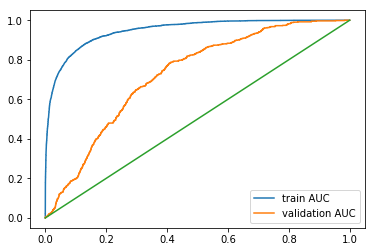

In [5]:
plot_roc_auc(model, X_train, X_val, y_train, y_val)

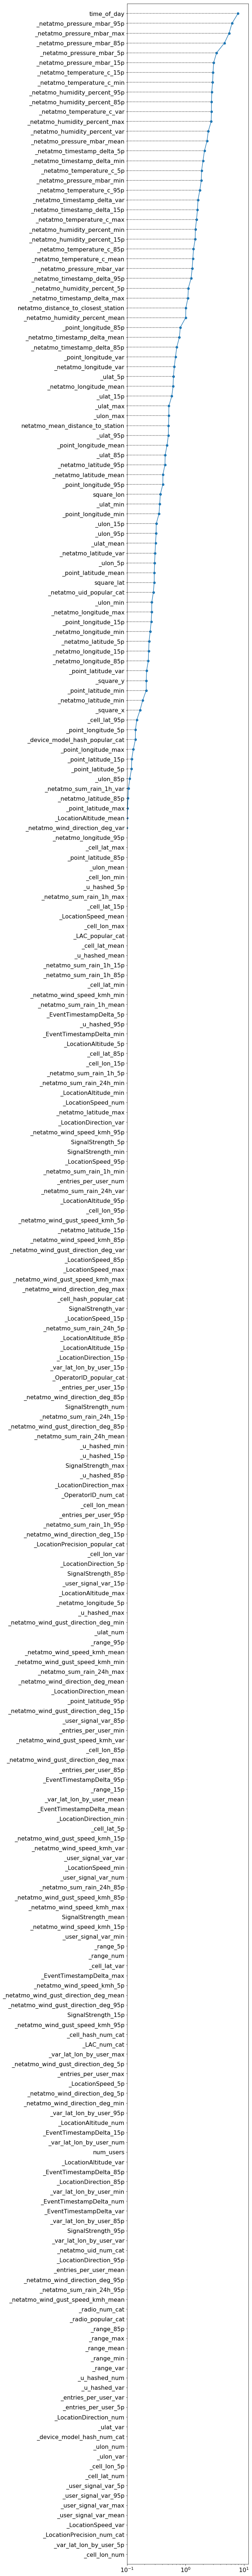

In [6]:
plot_feature_importances(model, X_train)

In [33]:
def stas_xgb(X_train, y_train, X_val, y_val=None):
    ytestxgb = np.zeros(X_val.shape[0])
    bgs = 1
    for bg in tqdm(range(bgs)):
        seed = bg + 1

#         model = CatBoostClassifier(random_seed=seed, thread_count=4) \
#                     .fit(X_train, y_train)
            
        model = CatBoostClassifier(iterations=1370,
                       loss_function='Logloss',
                       learning_rate=0.02,
                       thread_count=6,
                       l2_leaf_reg=10,
                       random_seed=seed) \
            .fit(X_train, y_train)
        
        ypredxgb = model.predict_proba(X_val)[:, 1]
        ytestxgb += ypredxgb
        
        if y_val is not None:
            print(bg, roc_auc_score(y_val, ytestxgb / (bg + 1.)), roc_auc_score(y_val, ypredxgb))
    
    ytestxgb /= bgs
    return ytestxgb    

## Final model and uploading the results

In [34]:
y_pred = stas_xgb(X, y, X_test)

A Jupyter Widget

In [ ]:
# model = CatBoostClassifier().fit(X, y)
# y_pred = model.predict_proba(X_test)[:,1]

In [35]:
prediction_for_one_city = test_block_ids.copy()
prediction_for_one_city["prediction"] = y_pred
prediction_for_one_city.to_csv("./intermediate_data/catboost_{}.csv".format(CITY))

prediction_for_one_city.head()

,city_code,sq_x,sq_y,hour_hash,prediction
0,16,6,1,1329378061886750011,0.019420
1,16,-8,5,3656781434124781193,0.015381
2,16,-11,-26,5283775109856712571,0.032879
3,16,10,-2,5722370507402590562,0.058151
4,16,-18,3,9453224544833540659,0.116914
